# Retirement Planner

---

## Environment Setup

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
# Set the random seed for resutls reproducibility (for testing purposes only)
np.random.seed(42)

---

## Portfolio Planner

In this activity, you will use the Alpaca API to grab historical data for a `60/40` portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [3]:
# Load .env enviroment variables
from dotenv import load_dotenv
# Set environment variables from the .env file
env_abs_path = 'C:/Users/danie/.env'    # System specific absolute path for .env
load_dotenv(dotenv_path=env_abs_path)

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [4]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker = ["SPY", "AGG"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

# Rename Columns
df.columns = ['AGG','SPY']

In [5]:
# Display sample data
df.head()

,AGG,SPY
2019-01-02 00:00:00-05:00,106.585,249.89
2019-01-03 00:00:00-05:00,107.020,244.46
2019-01-04 00:00:00-05:00,106.695,252.41
2019-01-07 00:00:00-05:00,106.470,254.40
2019-01-08 00:00:00-05:00,106.420,256.65


---

## Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:

1. Calculate the daily returns for the SPY and AGG closing prices.

2. Calculate volatility for both the SPY and AGG closing prices.

3. Find the last day's closing price for both stocks and save those as variables

4. Run a Monte Carlo Simulation of at least `100` iterations and generate at least `30` years of closing prices

**Hint:** There are `252` trading days per year, so the number of records to generate for each Monte Carlo run will be `252 days * 30 years`.

In [6]:
# Calculate the daily roi for the stocks
daily_returns = df.pct_change()

# Display sample data
daily_returns.dropna().head() # dropna for display

,AGG,SPY
2019-01-03 00:00:00-05:00,0.004081,-0.021730
2019-01-04 00:00:00-05:00,-0.003037,0.032521
2019-01-07 00:00:00-05:00,-0.002109,0.007884
2019-01-08 00:00:00-05:00,-0.000470,0.008844
2019-01-09 00:00:00-05:00,0.000564,0.004130


In [7]:
# Compute daily volatility
agg_stddev_daily = daily_returns.std()['AGG']
spy_stddev_daily = daily_returns.std()['SPY']

agg_stddev_daily,spy_stddev_daily

(0.002089826211646555, 0.007820053413439366)

In [8]:
# Calculate avg daily returns
agg_avg_daily = daily_returns.mean()['AGG']
spy_avg_daily = daily_returns.mean()['SPY']

agg_avg_daily,spy_avg_daily

(0.00021277231473764173, 0.0010401250682146959)

In [9]:
# Save the last day's closing price
agg_last_close = df['AGG'][-1]
spy_last_close = df['SPY'][-1]

agg_last_close,spy_last_close

(112.37, 321.92)

In [10]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()

# Initialize df for portfolio cumulative returns
portfolio_cum_returns = pd.DataFrame()

In [11]:
# Run the Monte Carlo Simulation

# loop through price projection, incrementing through number_simlutations: 500
for n in range(number_simulations):
    
    # set intial simulated price in list variable for each stock to the stocks last close price
    agg_simulated_prices = [agg_last_close]
    spy_simulated_prices = [spy_last_close]

    # loop through num_records to process for 252 days * 30 years
    for i in range(number_records):
        
        # calculate each simulated stock price for current trading day iteration
        agg_simulated_price = agg_simulated_prices[-1] * (1 + np.random.normal(agg_avg_daily, agg_stddev_daily))
        spy_simulated_price = spy_simulated_prices[-1] * (1 + np.random.normal(spy_avg_daily, spy_stddev_daily))
        
        # append each simulated price to each price list
        agg_simulated_prices.append(agg_simulated_price)
        spy_simulated_prices.append(spy_simulated_price)
    
    # Append the simulated prices of each stock price to the monty_carlo df
    monte_carlo['AGG'] = pd.Series(agg_simulated_prices)
    monte_carlo['SPY'] = pd.Series(spy_simulated_prices)

    # calculate daily returns of the simulated prices
    simulated_daily_returns = monte_carlo.pct_change()

    # set weights for the two stock portfolio
    weights = [0.4, 0.6]  # AGG=0.4 and SPY=0.6, in that order
    
    # calculate weighted returns of the portfolio with dot function
    weighted_daily_returns = simulated_daily_returns.dot(weights)

    # calculate cumulative returns from weighted daily returns
    portfolio_cum_returns[n] = (1 + weighted_daily_returns.fillna(0)).cumprod()

In [12]:
# Check that the simulation ran successfully
portfolio_cum_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000476,1.000536,0.998808,1.005394,1.011797,0.994452,0.997251,1.013277,1.000869,0.995376,...,1.002066,0.992709,1.001801,1.002671,0.996472,1.003160,1.001638,1.006800,0.998173,0.994765
2,1.008876,1.004699,1.003590,0.996711,1.009571,0.994247,0.994214,1.007199,1.000225,0.993036,...,1.005759,0.994517,1.003317,1.006181,0.997472,0.991774,1.002764,1.005408,0.996137,0.998871
3,1.008286,1.004228,1.003770,0.998232,1.007751,0.987669,0.998229,1.001361,1.000230,1.001279,...,1.006771,0.988444,1.004118,1.010565,0.993293,0.994454,1.008272,0.999144,0.998656,1.003328
4,1.013963,1.006575,1.008493,1.002636,1.013664,0.990972,1.003241,0.995491,1.002048,1.006036,...,1.004196,0.992123,1.004724,1.004423,0.994844,0.993782,1.005722,1.002248,0.996964,1.004095


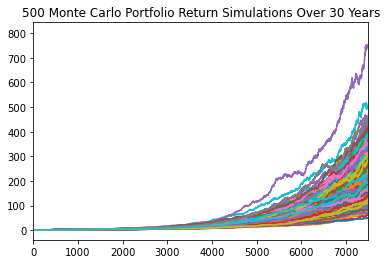

In [13]:
# Visualize the Simulation
title = f"{number_simulations} Monte Carlo Portfolio Return Simulations Over {int(number_records/252)} Years"
portfolio_cum_returns.plot(legend=None, title=title,xlim=(0,7500))

In [14]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
end_cum_returns = portfolio_cum_returns.iloc[-1, :]
end_cum_returns.head()

0    192.773859
1    171.964137
2    177.998514
3    138.466715
4    175.628015
Name: 7560, dtype: float64

In [15]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
# duplicate of above

In [16]:
# Display the 90% confidence interval for the ending returns
# use quantile to calculate 90% confidence level
confidence_interval = end_cum_returns.quantile(q=[0.05, 0.95])

confidence_interval

0.05    102.825606
0.95    379.341808
Name: 7560, dtype: float64

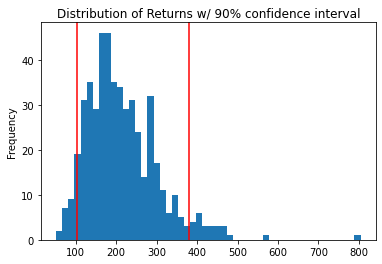

In [17]:
# Visualize the distribution of the ending returns
# plot probability distribution of final cumulative returns (simulated) with 90% confidence interval
plt.figure();
end_cum_returns.plot(kind='hist', title='Distribution of Returns w/ 90% confidence interval',bins=50)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

---

## Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at `30` years for the `10th`, `50th`, and `90th` percentiles?

2. Given an initial investment of `$20,000`, what is the expected return in dollars at the `10th`, `50th`, and `90th` percentiles?

3. Given the current projected annual income from the Plaid analysis, will a `4%` withdrawal rate meet or exceed that value at the `10th` percentile? Note: This is basically determining if retirement income is equivalent to current income.

4. How would a `50%` increase in the initial investment amount affect the `4%` retirement withdrawal? In other words, what happens if the initial investment had been bigger?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [18]:
# Compute cumulative returns
end_cum_returns = portfolio_cum_returns.iloc[-1, :]

# use quantile to calculate 10th percentile and 90th percentile
(cumulative_returns10th, cumulative_returns90th) = end_cum_returns.quantile(q=[0.10, 0.90])

# use quantile to calculate 50th percenile
cumulative_returns50th = end_cum_returns.quantile(q=[0.50, 0.50]).iloc[0]

# spot check cumulative returns values
cumulative_returns10th, cumulative_returns50th, cumulative_returns90th

(119.02748490144204, 199.0838571716875, 320.56154856359194)

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [19]:
# Set initial investment
initial_investment = 20000


# Compute expected portfolio return
# calculate portfolio return range in dollars for 10th, 50th, and 90th percentile
portfolio_return10 = initial_investment * cumulative_returns10th
portfolio_return50 = initial_investment * cumulative_returns50th
portfolio_return90 = initial_investment * cumulative_returns90th

# format portfolio returns to two decimal places to represent USD
formatted_portfolio_return10 = "{:.2f}".format(portfolio_return10)
formatted_portfolio_return50 = "{:.2f}".format(portfolio_return50)
formatted_portfolio_return90 = "{:.2f}".format(portfolio_return90)

#print results for 10th, 50th, and 90th percentile returns
print(f'Given a starting investment of {initial_investment},\r\n'
      f'The expected return at the 10th percentile is ${formatted_portfolio_return10},\r\n'
      f'The expected return at the 50th percentile is ${formatted_portfolio_return50},\r\n'
      f'The expected return at the 90th percentile is ${formatted_portfolio_return90}.\r\n')


Given a starting investment of 20000,
The expected return at the 10th percentile is $2380549.70,
The expected return at the 50th percentile is $3981677.14,
The expected return at the 90th percentile is $6411230.97.



### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [20]:
# Set Plaid's projected income
projected_income = 6085

# Calculate the 4% withdrawal for the ending return as retirement income
retirement_withdrawl_pct = 0.04
retirement_withdrawl = portfolio_return10 * retirement_withdrawl_pct

# format retirement_withdrawl for USD - display only
formatted_retirement_withdrawl = "{:.2f}".format(retirement_withdrawl)

# Determine if the retirement income meets or exceeds the current projected income
print(f'Based on 10th percentile return of ${formatted_portfolio_return10},\r\n'
      f'Does 4% retirement withdrawl (${formatted_retirement_withdrawl}) meet/exceed current projected annual income (${projected_income})? {retirement_withdrawl_pct >= retirement_withdrawl_pct}')
# Calculate the 4% withdrawal for the ending return as retirement income

# Determine if the retirement income meets or exceeds the current projected income


Based on 10th percentile return of $2380549.70,
Does 4% retirement withdrawl ($95221.99) meet/exceed current projected annual income ($6085)? True


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [21]:
# Re-calculate the retirement income with a 50% increase in the initial investment amount
bigger_initial_investment = 30000

# Compute expected portfolio return
# calculate portfolio return range in dollars for 10th percentile
new_portfolio_return10 = bigger_initial_investment * cumulative_returns10th

# Calculate the 4% withdrawal for the ending return as retirement income
new_retirement_withdrawl = new_portfolio_return10 * retirement_withdrawl_pct

# format retirement_withdrawl variables for USD - used for display only
formatted_new_retirement_withdrawl = "{:.2f}".format(new_retirement_withdrawl)
formatted_retirement_diff = "{:.2f}".format(new_retirement_withdrawl - retirement_withdrawl)

# Determine if the retirement income meets or exceeds the current projected income
#print(f'Based on 10th percentile (${formatted_new_retirement_withdrawl}) does 4% retirement withdrawl meet/exceed current projected annual income (${projected_income})? {retirement_withdrawl_pct >= retirement_withdrawl_pct}')
print(f'Updating the initial investment from ${initial_investment} to ${bigger_initial_investment} increases the 4% retirement income from ${formatted_retirement_withdrawl} to ${formatted_new_retirement_withdrawl}.\r\n'
     f'This is an additional ${formatted_retirement_diff}.')


Updating the initial investment from $20000 to $30000 increases the 4% retirement income from $95221.99 to $142832.98.
This is an additional $47610.99.


### Optional Challenge

Use the Monte Carlo data and calculate the cumulative returns at the `5%`, `50%`, and `95%` quartiles and plot this data as a line chart to see how the cumulative returns change over the life of the investment.

In this section, you need to calculate and plot the cumulative returns for the median and `90%` confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [22]:
# Compute projected returns
# Initialize df for portfolio percentile (5,50,95) cumulative returns
portfolio_projected_cum_returns = pd.DataFrame()

# set the intervals with quantile function
confidence90 = portfolio_cum_returns.quantile(axis=1,q=[0.05, 0.95])
confidence50 = portfolio_cum_returns.quantile(axis=1,q=[0.5, 0.5])

# assign 5,50,95 quantile returns to portfolio_projected_cum_returns columns
portfolio_projected_cum_returns['0.05'] = confidence90.iloc[0]
portfolio_projected_cum_returns['0.50'] = confidence50.iloc[0]
portfolio_projected_cum_returns['0.95'] = confidence90.iloc[1]


# Display sample data
portfolio_projected_cum_returns.tail()

,0.05,0.50,0.95
7556,103.646181,198.046067,382.125745
7557,103.048930,198.571688,381.218333
7558,103.123992,198.582408,380.240758
7559,102.888323,199.404147,379.940198
7560,102.825606,199.083857,379.341808


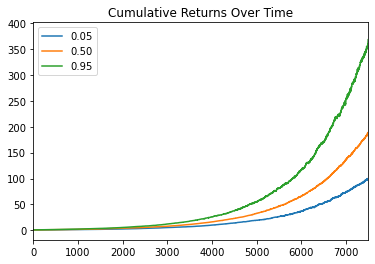

In [23]:
# Plot the cumulative returns over time
portfolio_projected_cum_returns.plot(title='Cumulative Returns Over Time',xlim=(0,7500))

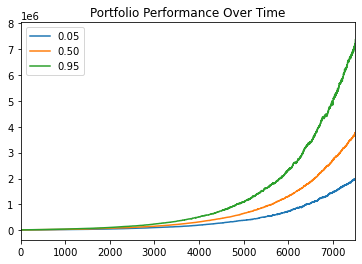

In [24]:
# Compute portfolio performance over time
# set initial investment
initial_investment = 20000

portfolio_projected_cum_pnl = initial_investment * portfolio_projected_cum_returns 

# Plot projected performance over time
portfolio_projected_cum_pnl.plot(title='Portfolio Performance Over Time',xlim=(0,7500))